In [179]:
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
from scipy.optimize import curve_fit
from uncertainties import ufloat
from uncertainties import unumpy as unp
import csv
import pandas as pd
import sympy as sym
import fprlib as fp
from scipy.signal import find_peaks

import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'axes.labelsize': 'large',
    'figure.dpi': 100,
})

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']}) #font na grafih je LaTexov
rc('text', usetex=True)

In [10]:
# Credit to M. Šifrar - modified to exclude the ipynb_checkpoints directrory if working in Jupyter by Dr.Kvass

# Import all measurements from the `./measurements` directory. Each measurement file
# is read into a numpy array (column-first) and added to the `meas_dict` (keys are
# filenames with extentions removed).
meas_dir = os.fsencode('./meritve')
meas_dict = {}
for fname in os.listdir(meas_dir):
    if fname!=b'.ipynb_checkpoints':
        with open(os.path.join(meas_dir, fname)) as file:
            meas = [[float(el) for el in row.split('\t')]
                for row in file.readlines()]
            meas_name = os.fsdecode(fname).removesuffix('.txt')
            meas_dict[meas_name] = np.array(meas).T

In [240]:
# Izračun frekvenc za N-je
calc_extremes = []
for x in [0,1,2,3]:
    for y in [0,1,2,3]:
        for z in [0,1,2,3]:
            a = (343/2*( (x/ufloat(0.567,0.010))**2 + (y/ufloat(0.385,0.010))**2 + (z/ufloat(0.240,0.010))**2 )**(1/2))
            if a.n < 1000 and not (x==0 and y==0 and z==0):
                calc_extremes.append(a)
                print("n(" + str(x) + ", " + str(y) + ", " + str(z) + ") = " + str( a ))

n(0, 0, 1) = 715+/-30
n(0, 1, 0) = 445+/-12
n(0, 1, 1) = 842+/-26
n(0, 2, 0) = 891+/-23
n(1, 0, 0) = 302+/-5
n(1, 0, 1) = 776+/-27
n(1, 1, 0) = 538+/-10
n(1, 1, 1) = 895+/-25
n(1, 2, 0) = 941+/-22
n(2, 0, 0) = 605+/-11
n(2, 0, 1) = 936+/-24
n(2, 1, 0) = 751+/-11
n(3, 0, 0) = 907+/-16


C:\Users\X\AppData\Local\Temp\ipykernel_21184\3337028480.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


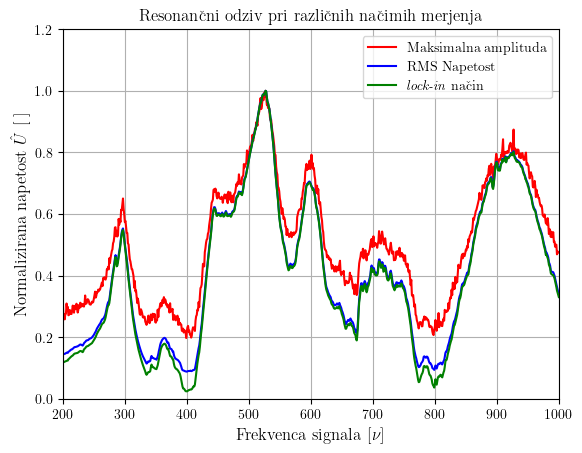

In [295]:
# Podatki za spekter brez absorberja
freq_0, U_0, U_0_sq, U_0_lock = meas_dict["spekter-z-absorberjem"]

# Normalizacija:
U_0 /= np.max(U_0)
U_0_sq /= np.max(U_sq)
U_0_lock /= np.max(U_lock)

# Grafiranje:

fig, ax = plt.subplots()

ax.plot(freq_0, U_0, c="r", ls="-", label=r"Maksimalna amplituda")
ax.plot(freq_0, U_0_sq, c="b", ls="-", label=r"RMS Napetost")
ax.plot(freq_0, U_0_lock, c="g", ls="-", label=r"\textit{lock-in} način")
# ax.errorbar(x_axis, y_axis, fmt=".", capsize=3, label='bar')
ax.grid(True, which="both")
plt.ylabel(r"Normalizirana napetost $\hat U$ [ ]")
plt.xlabel(r"Frekvenca signala [$\nu$]")
plt.legend(loc='upper right')
ax.set_ylim([0, 1.2])
ax.set_xlim([200, 1000])
plt.title("Resonančni odziv pri različnih načimih merjenja")
fig.show()
fig.savefig("res_curve", dpi=300, bbox_inches='tight', transparent=True)

[0.28684652103306546, 0.5563492200230873, 0.41224565549705006, 0.23876184783271726]


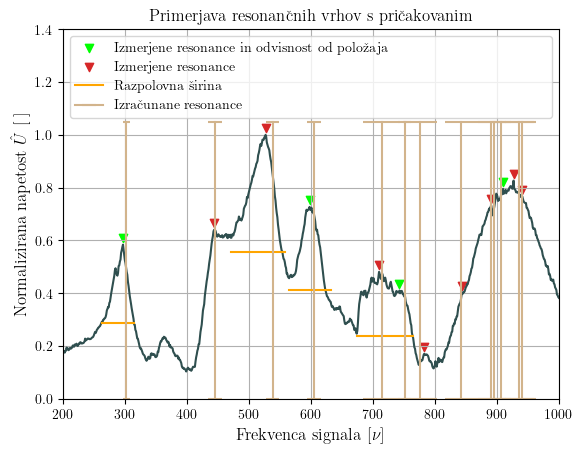

In [550]:
# Seznam izmerjenih vrhov
f_peaks = [297, 444, 527, 598, 710, 743, 783, 844, 891, 910, 927, 941]
U_peaks = [0.5839991210807646, 0.6401114834074448, 1.0, 0.7270569528854823, 0.4810019053660953, 0.41004378184595497, 0.170696760663243, 0.4013073256402486, 0.7323265855399952, 0.7952742888942375, 0.8265302650623981, 0.7670328165651265]

res = resonances(3)

U_0_mean = (U_0 + U_0_sq + U_0_lock) /3


fig, ax = plt.subplots()

x_axis = []
xerr = []
for i in calc_extremes:
    x_axis.append(i.n)
    xerr.append(i.s)
for i in range(len(x_axis)):
    if i == 0:
        ax.errorbar([x_axis[i], x_axis[i]], [0,1.05], xerr=xerr[i], c="tan", label=r"Izračunane resonance")
    else:
        ax.errorbar([x_axis[i], x_axis[i]], [0,1.05], xerr=xerr[i], c="tan")

ax.plot(freq_0, U_0_mean, c="darkslategrey")

for i in range(len(f_peaks)):
    if i == 1:
        ax.scatter(f_peaks[i], U_peaks[i] + 0.025, color='tab:red', marker='v', label=r'Izmerjene resonance')
    elif f_peaks[i] in [297, 598, 743, 910]:
        if f_peaks[i] == 297:
            ax.scatter(f_peaks[i], U_peaks[i] + 0.025, color='lime', marker='v', label=r"Izmerjene resonance in odvisnost od položaja")
        else:
            ax.scatter(f_peaks[i], U_peaks[i] + 0.025, color='lime', marker='v')
    else:
        ax.scatter(f_peaks[i], U_peaks[i] + 0.025, color='tab:red', marker='v')

amp1 = [0.2920407732233488, 0.5029233713733497, 0.36767043419729134, 0.2308244795758603]
amp2 = [0.2816522688427821, 0.6097750686728248, 0.45682087679680880, 0.24669921608957424]

amp_avg = []
for i in range(len([0.2920407732233488, 0.5029233713733497, 0.36767043419729134, 0.2308244795758603])):
    amp_avg.append([0.2920407732233488, 0.5029233713733497, 0.36767043419729134, 0.2308244795758603][i]/2 + [0.2816522688427821, 0.6097750686728248, 0.45682087679680880, 0.24669921608957424][i]/2)
#print(amp_avg)

idf =  [ 297, 527, 598, 710 ] #Ideal freq
hf1 = [ 263, 559, 632, 765 ] #Half height
hf2 = [ 315, 471, 565, 674 ] #other half 

for i in range(len(idf)):
    if i == 0:
        ax.plot([hf1[i],hf2[i]], [amp_avg[i], amp_avg[i]], c="orange", label=r"Razpolovna širina")
    else:
        ax.plot([hf1[i],hf2[i]], [amp_avg[i], amp_avg[i]], c="orange")

ax.grid(True, which="both")
plt.ylabel(r"Normalizirana napetost $\hat U$ [ ]")
plt.xlabel(r"Frekvenca signala [$\nu$]")
plt.legend(loc='best', mode="expand")
ax.set_ylim([0, 1.4])
ax.set_xlim([200, 1000])
plt.title("Primerjava resonančnih vrhov s pričakovanim")
fig.savefig("peaks", dpi=300, bbox_inches='tight', transparent=True)

In [555]:
# Manual mess... yeah i gave up at this point

U_peaks = [0.5839991210807646, 0.6401114834074448, 1.0, 0.7270569528854823, 0.4810019053660953, 0.41004378184595497, 0.170696760663243, 0.4013073256402486, 0.7323265855399952, 0.7952742888942375, 0.8265302650623981, 0.7670328165651265]
U_p_test =[0.5839991210807646, 0.6401114834074448, 1.0, 0.7270569528854823, 0.4810019053660953, 0.41004378184595497, 0.170696760663243, 0.4013073256402486, 0.7323265855399952, 0.7952742888942375, 0.8265302650623981, 0.7670328165651265]
for i in range(len(f_peaks)):
    U_p_test[i] = U_p_test[i]/2

U_span = 0.01
f_span =100


for i in range(len(freq_0)):
    f = freq_0[i]
    U = U_0_mean[i]
    for b in range(len(U_p_test)):
        if  U_p_test[b] - U_span < U < U_p_test[b] + U_span and f_peaks[b] - f_span < f < f_peaks[b] + f_span :
            skip = True
            #print(int(f), int(np.abs(f_peaks[b])), np.round(U, 5), np.round(np.abs(U-U_p_test[b]), 5))

#Ideal freq        [297, 527, 598, 710 ]
#Half height       [263, 559, 632, 765 ]
#delta             [034, 032, 034, 055 ]
#other half approx [331, 495, 564, 655 ]

#for i in range(len(freq_0)):
#    print(freq_0[i], np.abs(U_0_mean[i]-0.2308244795758603), U_0_mean[i])

#Ideal freq  [297, 527, 598, 710 ]
#Half height [263, 559, 632, 765 ]
#other half  [315, 471, 565, 674]
#Amplitude : [0.2920407732233488, 0.5029233713733497, 0.36767043419729134, 0.2308244795758603]
#Amplituda2: [0.2816522688427821, 0.6097750686728248, 0.45682087679680880, 0.24669921608957424]



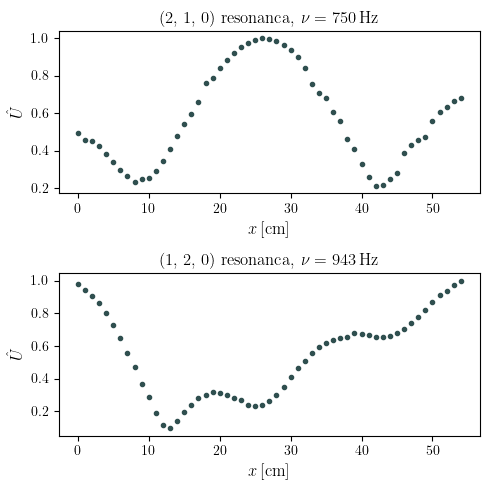

In [700]:
 # Plot reponse for different microphone placements.
fig, axs = plt.subplots(2, 1, figsize=[5, 5])

res_list = [
    (750, (2, 1, 0), meas_dict['750-distance']),
    (943, (1, 2, 0), meas_dict['914-distance'])    
]
for ax, (ν, (n_x, n_y, n_z), meas) in zip(axs, res_list):
    U_0, U_0_sq, U_0_lock = meas
    U_0_mean = U_0 + U_0_sq + U_0_lock
    U_0_mean /= np.max(U_0_mean)
    ax.scatter(range(len(U_0)), U_0_mean, color='darkslategrey', marker='.')
    
    # Labels and style.
    ax.set_title(f'({n_x}, {n_y}, {n_z}) resonanca, $\\nu = {ν:.0f}\\,\\mathrm{{Hz}}$')
    ax.set_xlabel(r'$x\,[\mathrm{cm}]$')
    ax.set_ylabel(r'$\hat U$')
fig.tight_layout()
fig.savefig("profiles2", dpi=300, bbox_inches='tight', transparent=True)

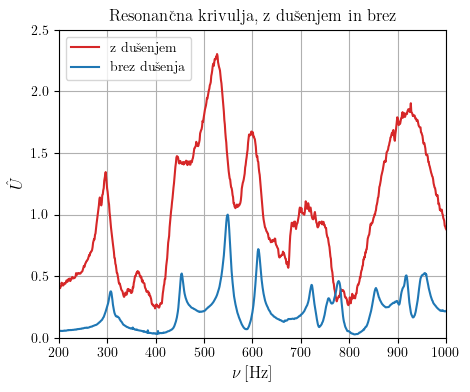

In [663]:
ν, U_0, U_0_sq, U_0_lock = meas_dict['spekter-brez-absorberja']
muff_ν, muff_U_0, muff_U_0_sq, muff_U_0_lock = meas_dict['spekter-z-absorberjem']
U_0_mean = (U_0 + U_0_sq + U_0_lock) / np.max(U_0 + U_0_sq + U_0_lock)
muff_U_0_mean = (muff_U_0 + muff_U_0_sq + muff_U_0_lock) / np.max(U_0 + U_0_sq + U_0_lock)


# Plot.
fig, ax = plt.subplots(1, 1, figsize=[5, 4])

ax.plot(muff_ν, muff_U_0_mean, color='tab:red', label='z dušenjem')
ax.plot(ν, U_0_mean, color='tab:blue', label='brez dušenja')

# Labels and style.
ax.set_title('Resonančna krivulja, z dušenjem in brez')
ax.set_xlabel(r'$\nu\,[\mathrm{Hz}]$')
ax.set_ylabel(r'$\hat U$')
ax.legend(loc='upper left')
ax.grid(True, which="both")
ax.set_ylim([0, 2.5])
ax.set_xlim([200, 1000])
fig.savefig('muff')

In [753]:
# hitrsot zvoka

list_rac_1 = [(306, (1,0,0)), (610, (2,0,0)), (750, (2,1,0)), (943, (1,2,0))]
list_rez = []
for i in list_rac_1:
    a = (343/2*( (i[1][0]/ufloat(0.567,0.010))**2 + (i[1][1]/ufloat(0.385,0.010))**2 + (i[1][2]/ufloat(0.240,0.010))**2 )**(1/2))
    list_rez.append(343* i[0]/a)
    print(i[0], 343* i[0]/a)

np.average(list_rez)

306 347+/-6
610 346+/-6
750 342+/-5
943 344+/-8


344.77112690044834+/-3.2042478936494074

In [748]:
freq_0, U_0, U_0_sq, U_0_lock = meas_dict["spekter-z-absorberjem"]

for i in range(len(freq_0)):
    if freq_0[i] in [306, 610, 750, 943]:
        print(freq_0[i], U_0[i], U_0_sq[i], U_0_lock[i])

306.0 0.501335876273205 0.3946968162801019 0.3868984398730371
610.0 0.6920855160696588 0.6169999468590084 0.6130913672159287
750.0 0.44834306368731836 0.3652006934181291 0.3557376915502806
943.0 0.7776107469747066 0.736626064076546 0.7329069978411414
